# Altair Plotting Dump

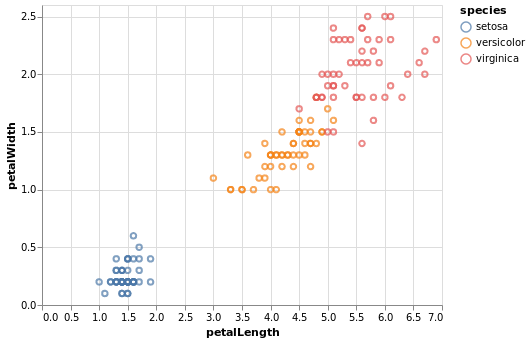

In [2]:
import altair as alt
from vega_datasets import data

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

iris = data.iris()

alt.Chart(iris).mark_point().encode(
    x='petalLength',
    y='petalWidth',
    color='species'
)

# HDF5 Dump

In [13]:
import h5py

import os
os.environ["MKL_NUM_THREADS"] = "3"

import argparse
import textwrap

import numpy as np
import pandas as pd
import george

from plotting import plot_mcmc_sampling_results
from GP_class import GPFit

In [30]:
filename = "../data/simulation_results_new/221/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt"
datadir = "./"
nwalkers = 100
niter = 1000
threads = 1
true_period = False
whitespace = False
nterms = 1
lsp = True

In [33]:
import pandas as pd
time, flux, flux_err = read_data(filename)

In [35]:
np.log(flux.max()-flux.min())

-2.522495157227649

In [31]:
def read_data(filename, whitespace=False, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=whitespace)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]

    return tsample, fsample, flux_err

def write_data(filename, sampler, asteroid, nwalkers, niter):
    """
    Write the sampler results as an HDF5 file, 
    with all the other info you might want.
    """
    
    with h5py.File(filename+".hdf5", "w") as f:
        f.create_dataset("chain", data=sampler.chain)

        if asteroid.true_period == None:
            f.attrs['true_period'] = 0
        else:
            f.attrs['true_period'] = asteroid.true_period

        f.attrs['walkers'] = nwalkers
        f.attrs['iterations'] = niter
        f.attrs['data_pts'] = asteroid.data_pts
        f.attrs['acceptance_faction'] = sampler.acceptance_fraction
        f.create_dataset("time", data= asteroid.time)
        f.create_dataset("flux", data = asteroid.flux)
        f.create_dataset("flux_err", data = asteroid.flux_err)


def main():
    # read in the data file
    time, flux, flux_err= read_data(filename, whitespace, datadir)

    asteroid = GPFit(time, flux, flux_err)
    asteroid.set_params()
    asteroid.set_walker_param_matrix(nwalkers)
    asteroid.set_gp_kernel()

    sampler = asteroid.run_emcee(niter=niter, nwalkers=nwalkers, threads=threads)

    write_data(filename, sampler, asteroid, nwalkers, niter)
    
    #plot_mcmc_sampling_results(np.array(asteroid.time), asteroid.flux, asteroid.flux_err,
    #                           asteroid.gp, sampler, namestr=filename + "test_plots",
    #                           true_period=true_period)



    return sampler



In [201]:
sampler = main()

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in log
/home/christina/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/christina/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [9]:
J_log_period = np.random.normal(size=100)*0.5 + np.log(4/24.) 
J_log_period

array([-1.86976814, -1.61830977, -1.31598066, -1.7694963 , -1.51997984,
       -1.56028902, -2.33949968, -1.81712606, -2.13472495, -1.47416286,
       -1.65325944, -1.29626118, -2.21230326, -1.85078456, -1.73254114,
       -2.34778101, -2.14674733, -1.5319967 , -2.04214416, -2.16262874,
       -1.46674792, -2.35971919, -2.53632732, -2.25729027, -1.05727904,
       -0.95757584, -1.53984026, -2.57458443, -2.0752584 , -1.96294479,
       -1.72417108, -1.63701592, -0.86885403, -2.45610284, -2.10863632,
       -2.53321492, -1.22739858, -1.55029278, -1.62966395, -1.97172201,
       -1.6830975 , -2.30726247, -2.02811367, -1.06784342, -2.20221776,
       -2.2351129 , -2.13082446, -1.45820095, -1.83561465, -1.90931053,
       -2.36436191, -1.48038161, -1.23591531, -1.87473318, -1.15889504,
       -0.91605584, -2.03945112, -2.16279462, -2.12366826, -0.85985242,
       -1.35370841, -2.09332339, -2.03121644, -2.31195051, -2.63763066,
       -2.60858696, -1.90538535, -1.75470196, -1.40212183, -0.99

In [78]:
import h5py
import numpy as np
import george
import corner
import matplotlib.pyplot as plt

In [79]:
filename = "../data/hdf5_testing/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt"

(10, 2000, 4)
true_period
walkers
iterations
data_pts
acceptance_faction
2000


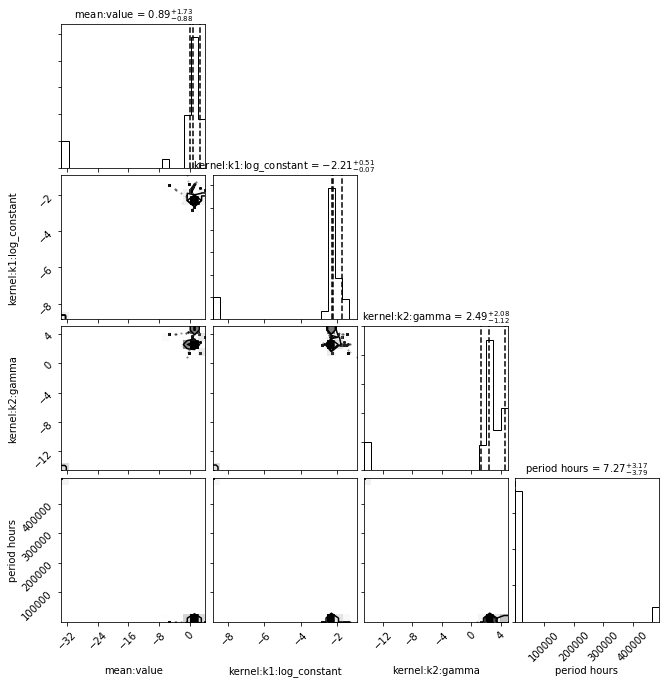

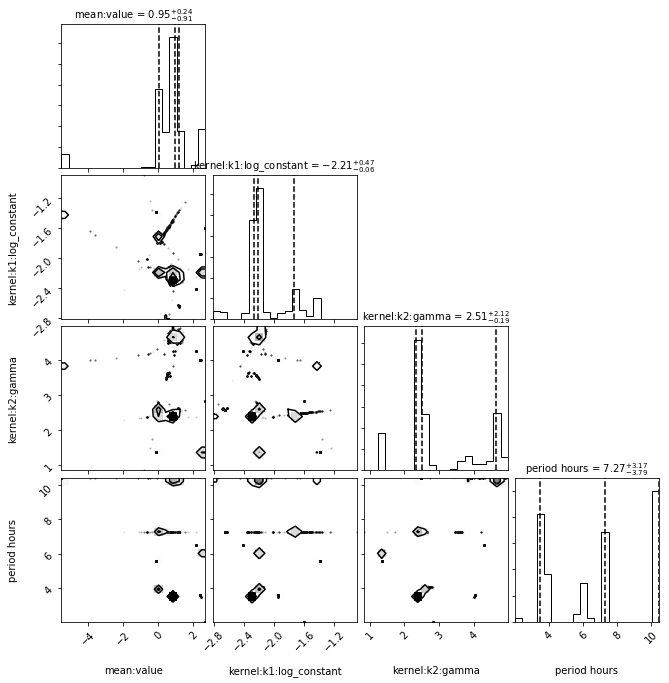

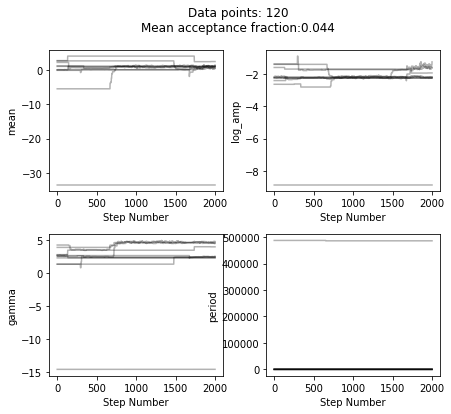

In [85]:
with h5py.File(filename+".hdf5", "r") as f:
    data = f['chain'][:]
    time = f['time'][:]
    flux = f["flux"][:]
    flux_err = f['flux_err'][:]
    print(data.shape)
    
    for key in f.attrs.keys():
        print(key)
       
    # set up the gp kernel again
    #(because for some reason it can't be saved)
    mean_flux = np.mean(flux)
    log_amp = np.log(flux.max()-flux.min())
    gamma = 1
    log_period = 0

    params = {"mean": mean_flux, "log_amp": log_amp, "gamma": gamma,"log_period": log_period}
    
    kernel = np.exp(params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = params["gamma"], log_period = params["log_period"])
    gp = george.GP(kernel, fit_mean=True, mean=params["mean"])
    gp.compute(time, flux_err)

    #print(gp)
    #print(f.attrs['acceptance_faction'])
    
    #plot full corner plot    
    data[:,:,3] = np.exp(data[:,:,3])*24.
    print(f.attrs["iterations"])

    labels = list(gp.get_parameter_names())
    labels[3] = 'period hours'

    corner.corner(data.reshape(f.attrs["walkers"]*f.attrs['iterations'],4), labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 10})
      #  plt.savefig(namestr + "_corner.pdf", format="pdf")

    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data= data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]

    corner.corner(masked_data, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 10})
      #  plt.savefig(namestr + "_corner.pdf", format="pdf")
       
    
    
    dims = ['mean', 'log_amp', 'gamma', 'period']
    
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    #if data_pts is not None:
    fig.suptitle("Data points: " + str(f.attrs['data_pts']) + "\nMean acceptance fraction:{0:.3f}".format(np.mean(f.attrs['acceptance_faction'])))

    #else:
    #    fig.suptitle("Mean acceptance fraction: 0:.3f}".format(np.mean(f.attrs['acceptance_fraction'])))


    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    x = np.arange(f.attrs['iterations'])

    for i in range(data.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(data.shape[0]):
            param = data[j,:,i]
            axs[i].plot(x, param, 'k-', alpha=0.3)
            # fit might guess period is time range of sampling

        flatchain = data[:,i]
    


In [ ]:
def plot_steps(sampler, dims=None, p0=None, data_pts=None):
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    if data_pts is not None:
        fig.suptitle("Data points: " + str(data_pts) + "\nMean acceptance fraction:{0:.3f}".format(np.mean(sampler.acceptance_fraction)))

    else:
        fig.suptitle("Mean acceptance fraction: 0:.3f}".format(np.mean(sampler.acceptance_fraction)))


    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    x = np.arange(sampler.iterations)

    for i in range(sampler.dim):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(len(sampler.chain)):
            param = sampler.chain[j,:,i]
            axs[i].plot(x, param, 'k-', alpha=0.3)
            # fit might guess period is time range of sampling

        flatchain = sampler.flatchain[:,i]


    return axs

In [72]:
np.exp(2.3)

9.974182454814718

In [74]:
scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(10))

-0.5524256126230083

In [49]:
import scipy.stats

p_start = [1.5,-2.5,5,-1]
cov_matrix = np.sqrt(np.diag(p_start)**2)
params = np.random.multivariate_normal(mean=p_start, cov=cov_matrix, size=(100))

#print(params[:,2])

p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[:,2]))
print(p_log_gamma)

[ -1.94564158  -1.93728538  -0.56989864  -1.3561169   -0.83955762
  -2.1434317   -0.57580317  -1.20574959  -2.09997118  -1.26785201
  -1.81346128  -0.71263239  -1.98387544  -3.29970636  -1.89732945
  -1.49350604  -0.95389178  -7.43182422  -1.13150394  -2.25002453
  -0.63270465  -0.55361167  -2.20726451  -1.18024103  -1.24055279
  -1.71492318  -1.79066776  -0.57252402          nan  -1.70445105
  -0.5639232   -1.17511395  -0.74109256  -0.78416457  -1.02683707
  -1.69235833  -0.64252525  -0.55680917  -1.35088066  -0.55780023
  -1.85359461  -0.76922154  -0.62836754  -0.61436899  -0.9624162
  -0.88764604  -1.0047562   -0.79690986  -1.56705239  -0.6389973
  -0.90490743  -0.87479225  -0.65255222  -2.27181252  -0.70780477
  -1.46869494  -0.60366223  -1.33063711  -0.92311176  -0.63376412
  -1.06332306  -1.08081944  -0.9929215   -8.64315982  -1.32514831
  -1.80115735  -0.57122167  -0.79855129  -0.64494561  -1.19997092
  -0.76011727  -1.05461528  -0.97699017  -1.3753884   -1.51097
  -1.05442483  

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/home/christina/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/christina/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [80]:
nmodels = 10
t_pred = None
npred = 1000

new_samples = f["flatchain"]
nsamples = new_samples.shape[0]
print(nsamples)

idx = np.rint(np.linspace(new_samples.attrs["iterations"]-1, nsamples-1, nmodels)).astype(int)
idx

100000


array([  999, 11999, 22999, 33999, 44999, 55999, 66999, 77999, 88999,
       99999])

In [82]:
time, flux, flux_err= read_data(filename, whitespace, datadir)

kernel = np.exp(self.params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = self.params["gamma"], log_period = self.params["log_period"])
gp = george.GP(kernel, fit_mean=True, mean=self.params["mean"])
gp.compute(self.time, self.flux_err)

if t_pred is None:
    t_pred = np.linspace(time[0], np.array(time)[-1], npred)
    
m_all = np.zeros((nmodels, t_pred.shape[0]))

In [90]:
for i,j in enumerate(idx):
    print(i,j)
    p = new_samples[j]
    #p = new_samples[j, -1]
    print(p)
    pnew = [p[0], p[1], p[2], p[3]]

    new_samples['gp'].set_parameter_vector(pnew)
    mean_model = gp.sample_conditional(fsample, t_pred)
    m_all[i] = mean_model

0 999
[ 3.21628044  1.10451466  7.90510497 -1.93164348]


ValueError: Field names only allowed for compound types

In [78]:
def plot_mcmc_sampling_results(tsample, fsample, flux_err, gp, sampler,
                          t_pred=None, true_lightcurve=None,
                          true_period=None, namestr="test",
                          nmodels=10, npred=1000):


    new_samples = sampler.flatchain
    #new_samples = sampler.chain


    ### plot light curve with example models ###

    # first, get the total number of available samples
    nsamples = new_samples.shape[0]

    # get some random samples from the total steps
    #idx = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nmodels)
    idx = np.rint(np.linspace(sampler.iterations-1, nsamples-1, nmodels)).astype(int)


    # if the array for the predictions isn't given, make one
    if t_pred is None:
        t_pred = np.linspace(tsample[0], tsample[-1], npred)

    # empty array for output
    m_all = np.zeros((nmodels, t_pred.shape[0]))

    # loop through the indices of samples, for each sample from the GP
    # conditional on the data points
    for i,j in enumerate(idx):
        p = new_samples[j]
        #p = new_samples[j, -1]
        print(p)
        pnew = [p[0], p[1], p[2], p[3]]

        gp.set_parameter_vector(pnew)
        mean_model = gp.sample_conditional(fsample, t_pred)
        m_all[i] = mean_model

    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    plot_lightcurve(tsample, fsample, true_lightcurve=true_lightcurve,
                        models=(t_pred, m_all), ax=ax)

    plt.tight_layout()
    plt.savefig(namestr + "_lc.pdf", format="pdf")